In [1]:
import datajoint as dj
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import sys

sys.path.insert(0, "..")
from create_days_df import *
from plot_days_info import *
sns.set_context("talk")

import dj_utils as dju

dj.conn(host="bdata00.pni.princeton.edu", reset=True)
bdata = dj.create_virtual_module("bdata", "bdata")  # connect to the bdata schema

%load_ext autoreload
%autoreload 2

[2024-07-04 14:13:39,882][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2024-07-04 14:13:41,188][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306
[2024-07-04 14:13:54,603][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2024-07-04 14:13:55,820][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


In [22]:
animal_ids = ["R010", "C222"]
days_df = create_days_df_from_dj(animal_ids, verbose=True)

Fetched data from SessionAggDate table from 2023-06-06 to 2024-07-03  
Today's data exits and has been added to SessionAggDate.

636 daily summaries fetched for ['R010', 'C222'] between 2023-06-06 and 2024-07-04


In [19]:
days_df.date.min().date()
)

('2023-06-06', '2024-07-04')

## Getting Today's Data

This is based on code that alvaro wrote [here](https://github.com/Brody-Lab/bl_pipeline_python/blob/main/scripts/session_agg_functions.py)



if date_max is >= today, then you need to create todays session data

if it's not, then you should be able to just load the data as is.


Okay we have the session agg table.

If date_max >= today and today is not in session agg table, then we need to get today's info.

If today's info is empty- no problem, we just wont append it yet.

Once all that is done, we can clean up things and make them pretty.

In [131]:
from create_days_df import fetch_session_agg_date_data

animal_ids = ["C222"]
date_min_query = "2024-06-15"
date_max_query = "2024-07-04"
SessAgg_df = fetch_session_agg_date_data(
    animal_ids, date_max=date_max_query, date_min=date_min_query
)

update_df = create_and_merge_todays_data_if_needed(
    SessAgg_df, animal_ids, date_max_query, verbose=True
)

Fetched data from SessionAggDate table from 2024-06-15 to 2024-07-02  

                Last date on the database is 2024-07-02 but user is querying data
                for 2024-07-04. Attempting to manually aggregate today's data
                
Today's data exits and has been added to SessionAggDate.


In [133]:
daily_summary_df = update_column_types(update_df)
daily_summary_df = rename_columns(daily_summary_df)
daily_summary_df = compute_additional_columns(daily_summary_df)

In [90]:
def create_and_merge_todays_data_if_needed(SessAgg_df, date_max: str, verbose=False):

    today = datetime.datetime.now().date()
    max_date_queried = datetime.datetime.strptime(date_max_query, "%Y-%m-%d").date()

    # Determine if we need to aggregate today's data under which conditions
    if len(SessAgg_df) == 0 and today <= max_date_queried:
        if verbose:
            print(
                f"""
                Database is empty for date range, but user is querying data
                for {today}. Attempting to manually aggregate today's data
                """
            )

        todays_df = dju.aggregate_todays_data(animal_ids)

    elif today > SessAgg_df.sessiondate.max() and today <= max_date_queried:
        if verbose:
            print(
                f"""
                Last date on the database is {SessAgg_df.sessiondate.max()} but user is querying data
                for {today}. Attempting to manually aggregate today's data
                """
            )

        todays_df = dju.aggregate_todays_data(animal_ids)

    else:
        if verbose:
            print("Today is not being queried or data already exists in the database.")

    # Add today's data to the database if it exists
    if not len(todays_df) == 0:
        print("Today's data exits and has been added to SessionAggDate.")
        aggregated_df = pd.concat([SessAgg_df, todays_df], axis=0, ignore_index=True)
        return aggregated_df
    else:
        print("No new data to add to SessionAggDate.")
        return SessAgg_df

In [94]:
new_df = create_and_merge_todays_data_if_needed(
    SessAgg_df, date_max_query, verbose=True
)


                Database is empty for date range, but user is querying data
                for 2024-07-04. Attempting to manually aggregate today's data
                
No new data to add to SessionAggDate.


In [85]:
today = datetime.datetime.now().date()
max_date_queried = datetime.datetime.strptime(date_max_query, "%Y-%m-%d").date()


if len(SessAgg_df) == 0 and today <= max_date_queried:
    print(
        f"""
          Database is empty for date range, but user is querying data
          for {today}. Attempting to manually aggregate today's data
          """
    )

    todays_df = aggregate_todays_data(animal_ids)

elif today > SessAgg_df.sessiondate.max() and today <= max_date_queried:
    print(
        f"""
          Last date on the database is {SessAgg_df.sessiondate.max()} but user is querying data
          for {today}. Attempting to manually aggregate today's data
          """
    )

    todays_df = aggregate_todays_data(animal_ids)

else:
    print(
        """
        Today is not being queried or data already exists in the database.
        """
    )

if not len(todays_df) == 0:
    print("Today's data exits and has been added.")
    updated_df = pd.concat([SessAgg_df, todays_df], axis=0, ignore_index=True)
    # return SessAgg_df
else:
    print("No new data to add.")
    updated_df = SessAgg_df


          Database is empty for date range, but user is querying data
          for 2024-07-04. Attempting to manually aggregate today's data
          
Today's data exits and has been added.


In [86]:
updated_df

,ratname,sessiondate,num_sessions,n_done_trials,hostname,starttime,endtime,total_correct,percent_violations,right_correct,left_correct,mass,tech,percent_target,volume,num_water,totalvol,num_rigwater
0,C222,2024-07-04,1,416,Rig29,18:44:47,02:25:50,0.9,0.07,0.9,0.9,NaN,NaN,0.000,0.000,1,12.14500,1


In [51]:
df = aggregate_todays_data(["R010"])

len(df)

0

In [72]:
sessions_df = aggregate_todays_sessions(["C222"])
sessions_df

,ratname,sessiondate,num_sessions,n_done_trials,hostname,starttime,endtime,total_correct,percent_violations,right_correct,left_correct
0,C222,2024-07-04,1,416,Rig29,18:44:47,02:25:50,0.9,0.07,0.9,0.9


In [46]:
def aggregate_todays_data(animal_ids: list = None) -> pd.DataFrame:

    sessions_df = aggregate_todays_sessions(animal_ids)
    mass_df = aggregate_todays_mass(animal_ids)
    water_df = aggregate_todays_water(animal_ids)
    rigwater_df = aggregate_todays_rigwater(animal_ids)

    todays_df = merge_tables(sessions_df, mass_df, water_df, rigwater_df)

    return todays_df


def merge_tables(df_sessions, df_mass, df_water, df_rigwater):

    df_session_mass = pd.merge(df_sessions, df_mass, how="left", on="ratname")
    df_session_mass = df_session_mass.drop(columns="date")

    df_session_mass_water = pd.merge(
        df_session_mass, df_water, how="left", left_on="ratname", right_on="rat"
    )
    df_session_mass_water = df_session_mass_water.drop(columns="date")
    df_session_mass_water["num_water"] = df_session_mass_water["num_water"].fillna(0)

    df_session_mass_water_rigwater = pd.merge(
        df_session_mass_water, df_rigwater, how="left", on="ratname"
    )
    df_session_mass_water_rigwater = df_session_mass_water_rigwater.drop(
        columns="dateval"
    )
    df_session_mass_water_rigwater = df_session_mass_water_rigwater.drop(columns="rat")
    df_session_mass_water_rigwater["num_rigwater"] = df_session_mass_water_rigwater[
        "num_rigwater"
    ].fillna(0)

    return df_session_mass_water_rigwater


def aggregate_todays_sessions(animal_ids: list = None) -> pd.DataFrame:

    # Create Query Keys
    todays_date = datetime.datetime.today().strftime("%Y-%m-%d")
    todays_session_query = {"sessiondate": todays_date}

    if animal_ids is not None:
        todays_session_query = [
            {"ratname": x, "sessiondate": todays_date} for x in animal_ids
        ]

    columns_query = [
        "ratname",
        "sessiondate",
        "n_done_trials",
        "starttime",
        "endtime",
        "hostname",
        "total_correct",
        "percent_violations",
        "right_correct",
        "left_correct",
    ]

    # Query the data
    todays_sessions = pd.DataFrame(
        (bdata.Sessions & todays_session_query).fetch(*columns_query, as_dict=True)
    )

    # If there are no sessions for today, return an empty dataframe, otherwise process the data
    if todays_sessions.shape[0] > 0:
        todays_sessions["sessiondate"] = pd.to_datetime(
            todays_sessions["sessiondate"], format="%Y-%m-%d"
        )
        todays_sessions["starttime"] = todays_sessions["starttime"].apply(
            lambda x: (datetime.datetime.min + x.to_pytimedelta()).time()
        )
        todays_sessions["endtime"] = todays_sessions["endtime"].apply(
            lambda x: (datetime.datetime.min + x.to_pytimedelta()).time()
        )
        todays_sessions["total_correct_n"] = (
            todays_sessions["total_correct"] * todays_sessions["n_done_trials"]
        )
        todays_sessions["percent_violations_n"] = (
            todays_sessions["percent_violations"] * todays_sessions["n_done_trials"]
        )
        todays_sessions["right_correct_n"] = (
            todays_sessions["right_correct"] * todays_sessions["n_done_trials"]
        )
        todays_sessions["left_correct_n"] = (
            todays_sessions["left_correct"] * todays_sessions["n_done_trials"]
        )

        # There can be multiple entries for the same date- now we aggregate them
        # to account for that
        todays_sessions_agg1 = todays_sessions.groupby("ratname").agg(
            {
                "sessiondate": [("sessiondate", "min")],
                "n_done_trials": [("num_sessions", "count"), ("n_done_trials", "sum")],
                "hostname": [("hostname", "min")],
                "starttime": [("starttime", "min")],
                "endtime": [("endtime", "max")],
                "total_correct_n": [("total_correct", "sum")],
                "percent_violations_n": [("percent_violations", "sum")],
                "right_correct_n": [("right_correct", "sum")],
                "left_correct_n": [("left_correct", "sum")],
            }
        )

        todays_sessions_agg1.columns = todays_sessions_agg1.columns.droplevel()

        todays_sessions_agg1["total_correct"] = (
            todays_sessions_agg1["total_correct"]
            / todays_sessions_agg1["n_done_trials"]
        )
        todays_sessions_agg1["percent_violations"] = (
            todays_sessions_agg1["percent_violations"]
            / todays_sessions_agg1["n_done_trials"]
        )
        todays_sessions_agg1["right_correct"] = (
            todays_sessions_agg1["right_correct"]
            / todays_sessions_agg1["n_done_trials"]
        )
        todays_sessions_agg1["left_correct"] = (
            todays_sessions_agg1["left_correct"] / todays_sessions_agg1["n_done_trials"]
        )

        todays_sessions_agg1 = todays_sessions_agg1.reset_index()
    else:
        todays_sessions_agg1 = pd.DataFrame(columns=columns_query)

    return todays_sessions_agg1


def aggregate_todays_mass(animal_ids: list = None) -> pd.DataFrame:

    # Create Query Keys
    todays_date = datetime.datetime.today().strftime("%Y-%m-%d")
    todays_session_query = {"date": todays_date}

    columns_query = ["ratname", "date", "mass", "tech"]

    if animal_ids is not None:
        todays_session_query = [{"ratname": x, "date": todays_date} for x in animal_ids]

    # Query the data
    todays_mass = pd.DataFrame(
        (ratinfo.Mass & todays_session_query).fetch(*columns_query, as_dict=True)
    )

    # There is only every 1 mass entry per day, so we can just return the dataframe
    if todays_mass.shape[0] > 0:
        todays_mass["date"] = pd.to_datetime(todays_date, format="%Y-%m-%d")
    else:
        todays_mass = pd.DataFrame(columns=columns_query)

    return todays_mass


def aggregate_todays_water(animal_ids: list = None) -> pd.DataFrame:

    # Query Keys
    todays_date = datetime.datetime.today().strftime("%Y-%m-%d")
    todays_session_query = {"date": todays_date}

    columns_query = ["rat", "date", "percent_target", "volume"]

    if animal_ids is not None:
        todays_session_query = [{"rat": x, "date": todays_date} for x in animal_ids]

    # Query the data
    todays_water = pd.DataFrame(
        (ratinfo.Water & todays_session_query).fetch(*columns_query, as_dict=True)
    )

    # There can be multiple entries for the same date- now we aggregate them
    if todays_water.shape[0] > 0:

        todays_water["date"] = pd.to_datetime(todays_water["date"], format="%Y-%m-%d")
        todays_water_agg1 = todays_water.groupby("rat").agg(
            {
                "date": [("date", "min")],
                "percent_target": [("percent_target", "max")],
                "volume": [("volume", "max"), ("num_water", "count")],
            }
        )

        todays_water_agg1.columns = todays_water_agg1.columns.droplevel()
        todays_water_agg1 = todays_water_agg1.reset_index()
    else:
        todays_water_agg1 = pd.DataFrame(columns=columns_query + ["num_water"])

    return todays_water_agg1


def aggregate_todays_rigwater(animal_ids: list = None) -> pd.DataFrame:

    # Query Keys
    todays_date = datetime.datetime.today().strftime("%Y-%m-%d")
    todays_session_query = {"dateval": todays_date}

    columns_query = ["ratname", "dateval", "totalvol"]

    if animal_ids is not None:
        todays_session_query = [
            {"ratname": x, "dateval": todays_date} for x in animal_ids
        ]

    # Query the data
    todays_rigwater = pd.DataFrame(
        (ratinfo.Rigwater & todays_session_query).fetch(*columns_query, as_dict=True)
    )

    # There can be multiple entries for the same date- now we aggregate them
    if todays_rigwater.shape[0] > 0:

        todays_rigwater["dateval"] = pd.to_datetime(
            todays_rigwater["dateval"], format="%Y-%m-%d"
        )
        todays_rigwater_agg1 = todays_rigwater.groupby("ratname").agg(
            {
                "dateval": [("dateval", "min")],
                "totalvol": [("totalvol", "max"), ("num_rigwater", "count")],
            }
        )

        todays_rigwater_agg1.columns = todays_rigwater_agg1.columns.droplevel()
        todays_rigwater_agg1 = todays_rigwater_agg1.reset_index()
    else:
        todays_rigwater_agg1 = pd.DataFrame(columns=columns_query + ["num_rigwater"])

    return todays_rigwater_agg1

In [14]:
max_date_queried

datetime.date(2023, 1, 1)

In [8]:
if 

datetime.date(2024, 7, 4)

In [6]:
dd.sessiondate.max()

datetime.date(2024, 7, 3)

In [ ]:

import os
import pathlib
import datetime
import datajoint as dj
import pandas as pd

def get_all_session_aggregate(subjects = None):

    

    bdata = dj.create_virtual_module('bdata', 'bdata')
    ratinfo = dj.create_virtual_module('ratinfo', 'ratinfo')

    df_agg_data = get_previous_agg_data(subjects=subjects,bdata=bdata)
    df_sessions = aggregate_todays_sessions(subjects=subjects, bdata=bdata)
    df_mass = aggregate_todays_mass(subjects=subjects, ratinfo=ratinfo)
    df_water = aggregate_todays_water(subjects=subjects, ratinfo=ratinfo)
    df_rigwater = aggregate_todays_rigwater(subjects=subjects, ratinfo=ratinfo)

    df_sessions = pd.merge(df_sessions, df_mass, how='left', on='ratname')
    df_sessions = df_sessions.drop(columns='date')
    df_sessions = pd.merge(df_sessions, df_water, how='left', left_on='ratname', right_on='rat')
    df_sessions = df_sessions.drop(columns='date')
    df_sessions['num_water'] = df_sessions['num_water'].fillna(0)
    df_sessions = pd.merge(df_sessions, df_rigwater, how='left', on='ratname')
    df_sessions = df_sessions.drop(columns='dateval')
    df_sessions = df_sessions.drop(columns='rat')
    df_sessions['num_rigwater'] = df_sessions['num_rigwater'].fillna(0)

    df_sessions = pd.concat([df_agg_data, df_sessions], axis=0, ignore_index=True)

    return df_sessions

def get_previous_agg_data(subjects=None, bdata=None):

    if bdata is None:
        bdata = dj.create_virtual_module('bdata', 'bdata')

    if subjects is not None:
        session_query = [{'ratname': x} for x in subjects]
    else:
        query_date = datetime.datetime.today() - datetime.timedelta(days=30)
        query_date = query_date.strftime('%Y-%m-%d')
        session_query = "sessiondate > '" + query_date + "'"

    columns_query = ['ratname', 'sessiondate', 'num_sessions', 'n_done_trials', 'hostname', 'starttime', 'endtime',
                    'total_correct', 'percent_violations', 'right_correct', 'left_correct',
                    'mass', 'tech', 
                    'percent_target', 'volume', 'num_water', 
                    'totalvol', 'num_rigwater']

    df_agg_data = pd.DataFrame((bdata.SessionAggDate & session_query).fetch(*columns_query,as_dict=True))

    if df_agg_data.shape[0] > 0:
        df_agg_data['sessiondate'] = pd.to_datetime(df_agg_data['sessiondate'], format='%Y-%m-%d')
        df_agg_data['starttime'] = df_agg_data['starttime'].apply(lambda x: (datetime.datetime.min + x.to_pytimedelta()).time())
        df_agg_data['endtime'] = df_agg_data['endtime'].apply(lambda x: (datetime.datetime.min + x.to_pytimedelta()).time())
    else:
        df_agg_data = pd.DataFrame(columns_query)

    return df_agg_data


def aggregate_todays_sessions(subjects = None, bdata=None):

    #try_find_conf_file()
    if bdata is None:
        bdata = dj.create_virtual_module('bdata', 'bdata')

    todays_date = datetime.datetime.today().strftime('%Y-%m-%d')
    todays_session_query = {'sessiondate': todays_date}

    if subjects is not None:
        todays_session_query = [{'ratname': x, 'sessiondate': todays_date} for x in subjects] 

    columns_query = ['ratname', 'sessiondate', 'n_done_trials',
                    'starttime', 'endtime', 'hostname', 'total_correct', 'percent_violations', 'right_correct', 'left_correct']

    todays_sessions = pd.DataFrame((bdata.Sessions & todays_session_query).fetch(*columns_query, as_dict=True))
    if todays_sessions.shape[0] > 0:
        todays_sessions['sessiondate'] = pd.to_datetime(todays_sessions['sessiondate'], format='%Y-%m-%d')
        todays_sessions['starttime'] = todays_sessions['starttime'].apply(lambda x: (datetime.datetime.min + x.to_pytimedelta()).time())
        todays_sessions['endtime'] = todays_sessions['endtime'].apply(lambda x: (datetime.datetime.min + x.to_pytimedelta()).time())
        todays_sessions['total_correct_n'] = todays_sessions['total_correct'] * todays_sessions['n_done_trials']
        todays_sessions['percent_violations_n'] = todays_sessions['percent_violations'] * todays_sessions['n_done_trials']
        todays_sessions['right_correct_n'] = todays_sessions['right_correct'] * todays_sessions['n_done_trials']
        todays_sessions['left_correct_n'] = todays_sessions['left_correct'] * todays_sessions['n_done_trials']


        todays_sessions_agg1 = todays_sessions.groupby('ratname').agg({
            'sessiondate': [('sessiondate', 'min')],
            'n_done_trials': [('num_sessions', 'count'), ('n_done_trials', 'sum')],
            'hostname': [('hostname', 'min')],
            'starttime': [('starttime', 'min')],
            'endtime': [('endtime', 'max')],
            'total_correct_n': [('total_correct', 'sum')],
            'percent_violations_n': [('percent_violations', 'sum')],
            'right_correct_n': [('right_correct', 'sum')],
            'left_correct_n': [('left_correct', 'sum')],
        })

        todays_sessions_agg1.columns = todays_sessions_agg1.columns.droplevel()

        todays_sessions_agg1['total_correct'] = todays_sessions_agg1['total_correct'] / todays_sessions_agg1['n_done_trials'] 
        todays_sessions_agg1['percent_violations'] = todays_sessions_agg1['percent_violations'] / todays_sessions_agg1['n_done_trials'] 
        todays_sessions_agg1['right_correct'] = todays_sessions_agg1['right_correct'] / todays_sessions_agg1['n_done_trials'] 
        todays_sessions_agg1['left_correct'] = todays_sessions_agg1['left_correct'] / todays_sessions_agg1['n_done_trials'] 

        todays_sessions_agg1 = todays_sessions_agg1.reset_index()
    else:
        todays_sessions_agg1 = pd.DataFrame(columns=columns_query)

    return todays_sessions_agg1

def aggregate_todays_mass(subjects = None, ratinfo=None):

    if ratinfo is None:
        ratinfo = dj.create_virtual_module('ratinfo', 'ratinfo')

    todays_date = datetime.datetime.today().strftime('%Y-%m-%d')
    todays_session_query = {'date': todays_date}

    columns_query = ['ratname', 'date', 'mass', 'tech']

    if subjects is not None:
        todays_session_query = [{'ratname': x, 'date': todays_date} for x in subjects] 

    todays_mass = pd.DataFrame((ratinfo.Mass & todays_session_query).fetch(*columns_query, as_dict=True))

    if todays_mass.shape[0] > 0:
        todays_mass['date'] = pd.to_datetime(todays_date, format='%Y-%m-%d')
    else:
        todays_mass = pd.DataFrame(columns=columns_query)

    return todays_mass
    
def aggregate_todays_water(subjects = None, ratinfo=None):

    if ratinfo is None:
        ratinfo = dj.create_virtual_module('ratinfo', 'ratinfo')

    todays_date = datetime.datetime.today().strftime('%Y-%m-%d')
    todays_session_query = {'date': todays_date}

    columns_query = ['rat', 'date', 'percent_target', 'volume']

    if subjects is not None:
        todays_session_query = [{'rat': x, 'date': todays_date} for x in subjects] 

    todays_water = pd.DataFrame((ratinfo.Water & todays_session_query).fetch(*columns_query, as_dict=True))

    if todays_water.shape[0] > 0:

        todays_water['date'] = pd.to_datetime(todays_water['date'], format='%Y-%m-%d')
        todays_water_agg1 = todays_water.groupby('rat').agg({
            'date': [('date', 'min')],
            'percent_target': [('percent_target', 'max')],
            'volume': [('volume', 'max'), ('num_water', 'count')]
        })

        todays_water_agg1.columns = todays_water_agg1.columns.droplevel()
        todays_water_agg1 = todays_water_agg1.reset_index()
    else:
        todays_water_agg1 = pd.DataFrame(columns=columns_query)
    
    return todays_water_agg1


def aggregate_todays_rigwater(subjects = None, ratinfo=None):

    if ratinfo is None:
        ratinfo = dj.create_virtual_module('ratinfo', 'ratinfo')

    todays_date = datetime.datetime.today().strftime('%Y-%m-%d')
    todays_session_query = {'dateval': todays_date}

    columns_query = ['ratname', 'dateval', 'totalvol']

    if subjects is not None:
        todays_session_query = [{'ratname': x, 'dateval': todays_date} for x in subjects] 

    todays_rigwater = pd.DataFrame((ratinfo.Rigwater & todays_session_query).fetch(*columns_query, as_dict=True))

    if todays_rigwater.shape[0] > 0:

        todays_rigwater['dateval'] = pd.to_datetime(todays_rigwater['dateval'], format='%Y-%m-%d')
        todays_rigwater_agg1 = todays_rigwater.groupby('ratname').agg({
            'dateval': [('dateval', 'min')],
            'totalvol': [('totalvol', 'max'), ('num_rigwater', 'count')]
        })

        todays_rigwater_agg1.columns = todays_rigwater_agg1.columns.droplevel()
        todays_rigwater_agg1 = todays_rigwater_agg1.reset_index()
    else:
        todays_rigwater_agg1 = pd.DataFrame(columns=columns_query)
    
    return todays_rigwater_agg1

## Building Query

In [3]:
def create_days_df_from_dj_v2(
    animal_ids: list, date_min: str, date_max: str, verbose: bool = False
):
    """
    Function to fetch and format day level summary from
    SessionAgg Table in the bdata schema.

    params
    ------
    animal_ids : list (optional, default = None)
        list of animal ids to query.
    date_min : str (optional, default = "2000-01-01")
        minimum date to query in YYYY-MM-DD format, e.g. "2022-01-04"
    date_max : str (optional, default = "2030-01-01")
        maximum date to query in YYYY-MM-DD format, e.g. "2022-01-04"
    verbose : bool (optional, default = False)
        whether to print out verbose statements

    returns
    -------
    daily_summary_df : pd.DataFrame
        data frame containing day-level summary info for all animals
        in `animal_ids` between `date_min` and `date_max`
    """

    # create keys
    subject_query = [{"ratname": animal_id} for animal_id in animal_ids]
    date_query = f"sessiondate >= '{date_min}' and sessiondate <= '{date_max}'"

    SessAggdf = pd.DataFrame(
        (bdata.SessionAggDate() & date_query & subject_query).fetch(as_dict=True)
    )

    daily_summary_df = update_column_types(SessAggdf)
    daily_summary_df = rename_columns(daily_summary_df)
    daily_summary_df = compute_additional_columns(daily_summary_df)

    return daily_summary_df


def update_column_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to update the column types of the SessionAgg data frame
    to the appropriate types. This function is necessary because the
    some variables (e.g. Mass) get read in as objects rather than floats
    due to Nans. Additionally, the date columns need to be converted to
    datetime objects.

    params
    ------
    df : pd.DataFrame
        data frame containing the session level summary info directly
        from the SessionAgg table in the bdata schema of DataJoint

    returns
    -------
    df : pd.DataFrame
        data frame with the appropriate column types
    """

    incorrect_object_cols = ["mass", "percent_target", "volume", "totalvol"]
    df[incorrect_object_cols] = df[incorrect_object_cols].astype(float)
    df["sessiondate"] = pd.to_datetime(df["sessiondate"])

    return df


def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to rename the columns of the SessionAgg data frame to
    more human-readable names.

    params
    ------
    df : pd.DataFrame
        data frame containing the session level summary info directly
        from the SessionAgg table in the bdata schema of DataJoint

    returns
    -------
    df : pd.DataFrame
        data frame with the appropriate column names
    """

    column_name_dict = {
        "ratname": "animal_id",
        "sessiondate": "date",
        "totalvol": "rig_volume",
        "volume": "pub_volume",
        "total_correct": "hit_rate",
        "percent_violations": "viol_rate",
        "hostname": "rigid",
    }

    df = df.rename(columns=column_name_dict)

    return df


def compute_additional_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to compute additional columns for the SessionAgg data frame
    that are not directly available in the table. This includes X
    params
    ------
    df : pd.DataFrame
        data frame containing the session level summary info directly
        from the SessionAgg table in the bdata schema of DataJoint

    returns
    -------
    df : pd.DataFrame
        data frame with the additional columns added
    """

    # training duration
    df["train_dur_hrs"] = (df.endtime - df.starttime).dt.total_seconds() / 3600
    df["trial_rate"] = (df.n_done_trials / df.train_dur_hrs).round(2)
    df["starttime_hrs"] = df.starttime.dt.total_seconds() / 3600
    df["endtime_hrs"] = df.endtime.dt.total_seconds() / 3600
    df["side_bias"] = df.right_correct - df.left_correct
    df["volume_target"] = (df.percent_target / 100 * df.mass).round(2)
    df["water_diff"] = df.pub_volume + df.rig_volume - df.volume_target

    return df

In [4]:
animal_ids = ["R010"]
date_min = "2024-05-20"
date_max = "2024-05-25"

new_df = create_days_df_from_dj_v2(animal_ids, date_min, date_max, verbose=True)
old_df = create_days_df_from_dj(animal_ids, date_min, date_max, verbose=True) #NOTE this function no longer exists!


fetched 6 daily summaries for R010 from dj between 2024-05-20 and 2024-05-25


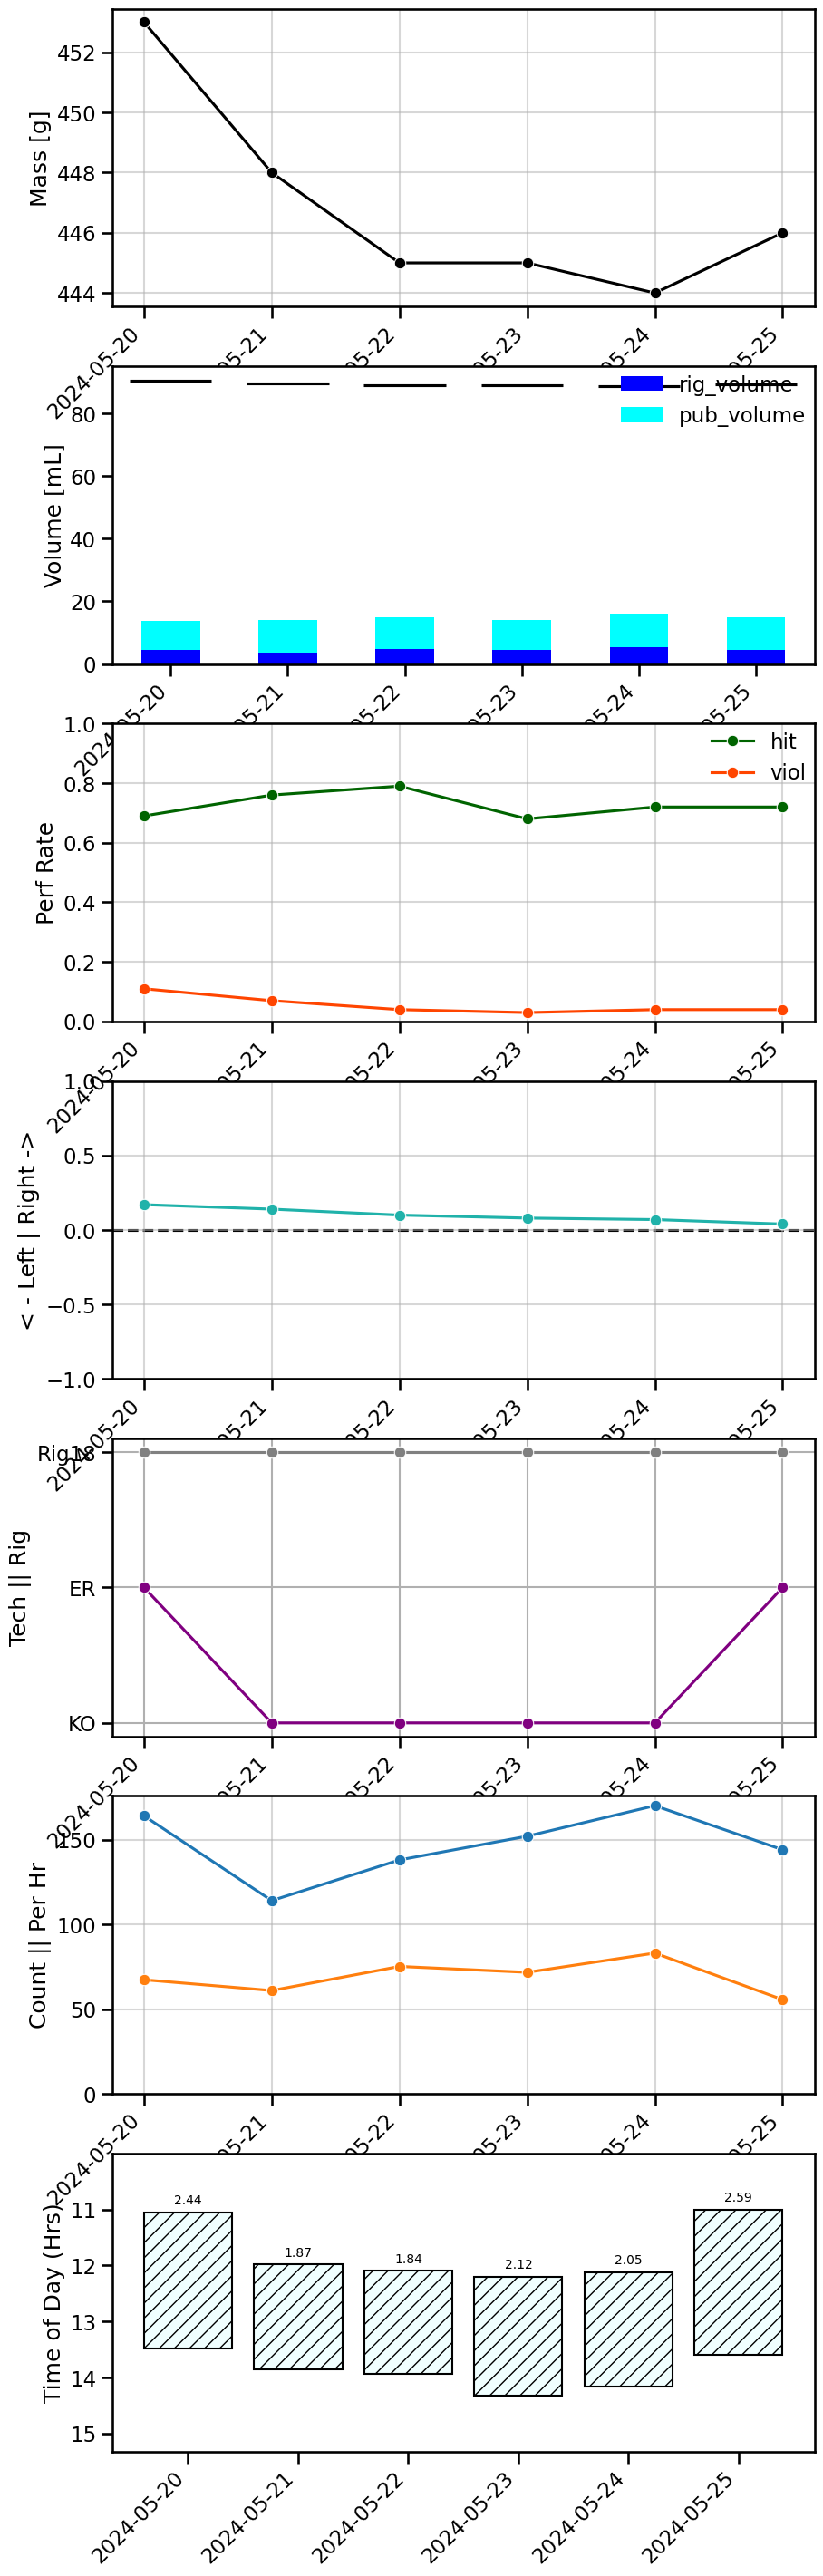

In [46]:
n_plots = 7
fig, ax = plt.subplots(n_plots, 1, figsize=(10, 5 * n_plots), sharey=False)

plot_mass(new_df, ax[0])

plot_water_restriction(new_df, ax[1])

plot_performance(new_df, ax[2])

plot_side_bias(new_df, ax[3])

plot_rig_tech(new_df, ax[4])

plot_trials(new_df, ax[5])

plot_run_time(new_df, ax[6])

## New Plots

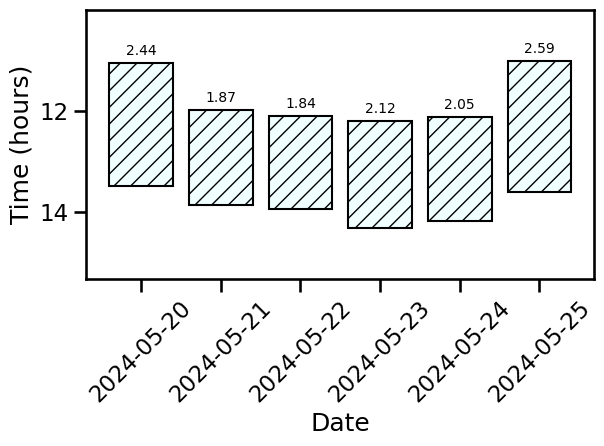

In [34]:
fig, ax = plt.subplots()
for _, row in new_df.iterrows():
    duration = row["endtime_hrs"] - row["starttime_hrs"]
    ax.bar(
        row["date"],
        duration,
        bottom=row["starttime_hrs"],
        width=0.8,
        align="center",
        color="azure",
        edgecolor="black",
        hatch="//",
    )
    ax.text(
        row["date"],
        row["starttime_hrs"] - 0.1,  # position the text slightly above the bar
        f"{duration:.2f}",
        ha="center",  # horizontal alignment
        va="bottom",  # vertical alignment
        fontsize=10,  # font size
        color="black",  # text color
    )

# extend the ylim a bit to make the plot look better based on the data
ax.set_ylim(new_df.starttime_hrs.min() - 1, new_df.endtime_hrs.max() + 1)

ax.invert_yaxis()
ax.set_xlabel("Date")
ax.set_ylabel("Time (hours)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'float'

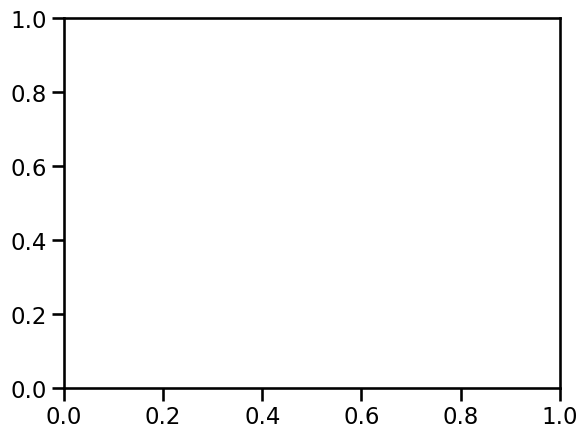

In [16]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
for _, row in new_df.iterrows():
    # ax.bar(
    #     row["date"],
    #     row["endtime_hrs"] - row["starttime_hrs"],
    #     bottom=row["starttime_hrs"],
    #     width=0.8,
    #     align="center",
    #     color="k",
    # )
    rect = patches.Rectangle(
        (row["date"], row["starttime_hrs"]),
        0.8,
        row["endtime_hrs"] - row["starttime_hrs"],
        fill=False,
        edgecolor="blue",
    )
    ax.add_patch(rect)

ax.invert_yaxis()
ax.set_xlabel("Date")
ax.set_ylabel("Time (hours)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()